# Part 0: Choose pretrained image classification model and images to be explained

## Imports

In [1]:
# gen
import os
import urllib.request
import requests
import time
import numpy as np
import cv2
import glob
from pathlib import Path
from tqdm import tqdm


# torch
import torch
import torchvision.models as models
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


# sklearn
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

# visualization
import matplotlib.pyplot as plt
from PIL import Image
from bs4 import BeautifulSoup



## Part 0: get the model

In [2]:
model = models.vgg16(pretrained=True)
model.eval()
pass

C:\Users\User\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
image_dir = "images"

### Download images, imagenet classes

In [4]:
def download_unsplash_image(url):
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        image_element = soup.find("meta", property="og:image")
        if image_element:
            image_url = image_element["content"]
            image_response = requests.get(image_url)
            if image_response.status_code == 200:
                timestamp = int(time.time())
                filename = f"images/image_{timestamp}.jpg"
                with open(filename, "wb") as f:
                    f.write(image_response.content)
                print(f"Image downloaded successfully as '{filename}'!")
            else:
                print("Failed to download the image.")
        else:
            print("Image URL not found on the page.")
    else:
        print("Failed to retrieve the page.")


In [6]:
Path(image_dir).mkdir(exist_ok=True, parents=True)
# Download a turtle image
turtle_image_url = 'https://unsplash.com/photos/Oj8w6hWC0dU'
download_unsplash_image(turtle_image_url)

# # Download a dog image
dog_image_url = 'https://unsplash.com/photos/T-0EW-SEbsE'
download_unsplash_image(dog_image_url)

image_url1 = 'https://unsplash.com/photos/fjW9KbfLcyA'
download_unsplash_image(image_url1)


# Define the URL to download the ImageNet class labels
url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"

# Define the filename to save the class labels
filename = "imagenet_classes.txt"

# Download the class labels
urllib.request.urlretrieve(url, filename)

print("ImageNet class labels downloaded successfully!")


Image downloaded successfully as 'images/image_1687034142.jpg'!
Image downloaded successfully as 'images/image_1687034143.jpg'!
Image downloaded successfully as 'images/image_1687034144.jpg'!
ImageNet class labels downloaded successfully!


In [7]:
with open("imagenet_classes.txt", "r") as f:
    class_names = [line.strip() for line in f.readlines()]

## Part 1: Choose pretrained image classification model

In [8]:
# visualize the images in the folder 'images', and put in the title the vgg prediction of the image

# Define the transformation for preprocessing the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

def predict_image(pil_image, k):
    im = transform(pil_image)
    im = im.unsqueeze(0)
    with torch.no_grad():
        outputs = model(im)
    _, predicted_indices = torch.topk(outputs, k=k)
    predicted_indices = predicted_indices.squeeze().tolist()
    return predicted_indices

def read_image_and_inference_and_plot(image_path, plot=False):
    orig_im = Image.open(image_path)

    predicted_indices = predict_image(orig_im, k=3)
    print("Top predicted classes:")
    for index in predicted_indices:
        print(f"{class_names[index]}")

    if plot:
        fig = plt.figure(figsize=(8, 12))
        plt.imshow(orig_im)
        plt.title(f"{class_names[predicted_indices[0]]}")
        plt.show()

    top_1_class_name = class_names[predicted_indices[0]]
    
    return orig_im, predicted_indices[:3], top_1_class_name
    


#### Vosualize image and their predictions

Top predicted classes:
"snorkel",
"loggerhead sea turtle",
"scuba diver",


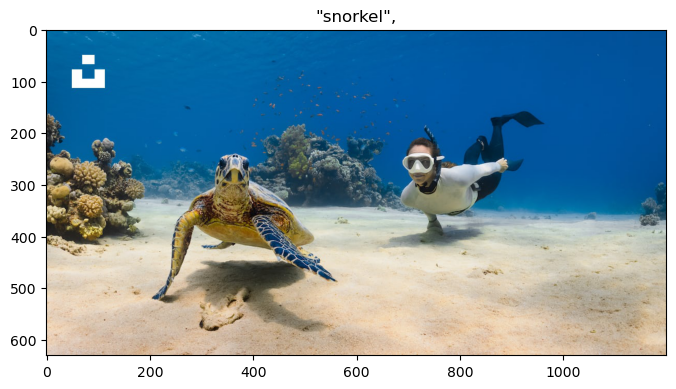

Top predicted classes:
"Yorkshire Terrier",
"Australian Terrier",
"Miniature Schnauzer",


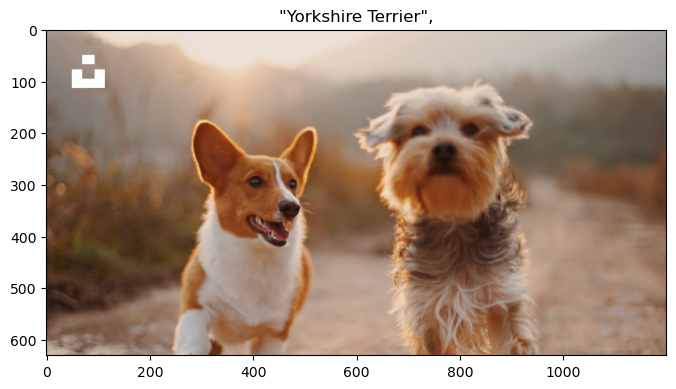

Top predicted classes:
"printer",
"toaster",
"tiger cat",


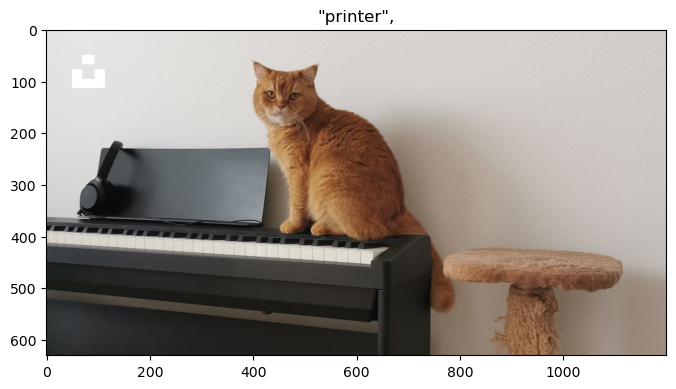

In [9]:
for image_path in Path(image_dir).iterdir():
    if'.jpg' in str(image_path):
        read_image_and_inference_and_plot(image_path, plot=True)


In [10]:
def get_super_pixels(image, region_size):
    image_lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    slic = cv2.ximgproc.createSuperpixelSLIC(image_lab, region_size=region_size)
    slic.iterate(10)  # Number of iterations for refinement
    labels = slic.getLabels()
    mask = slic.getLabelContourMask()
    result = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    result = cv2.addWeighted(image, 0.5, result, 0.5, 0)
    return result, labels


There are 121 super pixels types


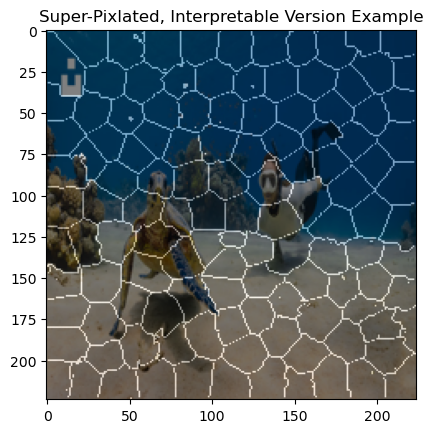

In [11]:
# example:
image_path = Path(glob.glob("images/*.jpg")[0])
image = np.array(Image.open(image_path).resize((224, 224)))
result, labels = get_super_pixels(image, region_size=20)
print(f"There are {len(np.unique(labels))} super pixels types")
plt.imshow(result)
plt.title("Super-Pixlated, Interpretable Version Example")
plt.show()


In [12]:
# using the labels, create a new image where each super pixel is colored with the average color of the super pixel
def get_average_color(image, labels):
    unique_labels = np.unique(labels)
    average_colors = []
    for label in unique_labels:
        indices = np.where(labels == label)
        average_color = np.mean(image[indices], axis=0)
        average_colors.append(average_color)
    return average_colors


def plot_image_with_average_colors(image, labels, average_colors):
    unique_labels = np.unique(labels)
    for label in unique_labels:
        indices = np.where(labels == label)
        image[indices] = average_colors[label]
    plt.imshow(image)
    plt.show()

There are 121 average colors


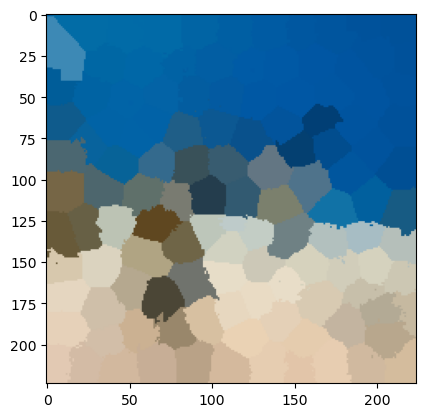

In [13]:
average_colors = get_average_color(image, labels)
print(f"There are {len(average_colors)} average colors")
plot_image_with_average_colors(image, labels, average_colors)


In [14]:
def gen_random_perturbations(img, one_hot_labels, perturbation_param=5, region_size=40, num_perturbations=500, plot=False):
    """
    Returns a list of perturbations, images with random superpixels removed, and the labels of the perturbations ready for training
    (1 row for each perturbation, with num_of_super_pixels columns - 1 if the superpixel is not removed, 0 if it is)
    """
    img = np.array(img)
    local_dataset = []
    local_dataset_labels = []
    _, orig_perturbed_labels = get_super_pixels(img, region_size=region_size)
    num_of_super_pixels = len(np.unique(orig_perturbed_labels))
    for _ in tqdm(range(num_perturbations)):
        perturbation = np.random.randint(perturbation_param, size=num_of_super_pixels)

        # Apply perturbation to the interpretable instances == superpixels
        perturbed_instance, perturbed_labels = np.copy(img), np.copy(orig_perturbed_labels)

        labels_for_training = np.zeros((1, num_of_super_pixels))

        for i in range(num_of_super_pixels):
            if perturbation[i] == 0:
                # Exclude the superpixel
                indices = np.where(one_hot_labels[:, :, i] == 1)
                perturbed_instance[indices] = 128 #np.random.randint(256)  # Set random intensity value for the perturbed region
                perturbed_labels[indices] = 0  # No superpixel

        unique_labels = np.unique(perturbed_labels)
        for label in unique_labels:
            labels_for_training[:, label] = 1

        local_dataset.append(perturbed_instance)
        local_dataset_labels.append(labels_for_training)

    if plot:
        # Plot the last perturbed instance
        plt.imshow(perturbed_instance)
        plt.title("Perturbed instance")
        plt.show()

    return local_dataset, local_dataset_labels


In [15]:
def calculate_euclidean_distance(orig_img, perturbed_img):
    euclidean_distance = np.sqrt(np.sum((orig_img - perturbed_img) ** 2))
    return euclidean_distance


def calc_similarity(orig_img, perturbed_img):
    """proximity measure between the original image and the perturbed image"""
    SIGMA = 2000
    orig_img = np.array(orig_img)
    perturbed_img = np.array(perturbed_img)
    euc_distance = 1 - calculate_euclidean_distance(orig_img, perturbed_img)
    proximity_measure = np.e ** - ( (euc_distance / SIGMA) ** 2 )
    return proximity_measure

In [16]:
def fit_linear_model_and_return_important_features(data, labels, proximity_measures, num_of_super_pixels, verbose=False, n=3):
    """
    Fit a linear model with locally weighted loss (using 𝜋') and 𝐿! regularization on the
    generated dataset. Use K-Lasso for feature selection.
    uses pytorch
    """
    loss_fn = nn.MSELoss()
    lasso_loss = nn.L1Loss()
    model = nn.Linear(num_of_super_pixels, 1)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
    num_of_images = len(data)

    for epoch in range(35):
        for i in range(num_of_images):
            loss = 0
            super_pixels_in_current_perm_one_hot_encoded = data[i]
            label = labels[i]
            proximity_measure = proximity_measures[i]
            image = torch.tensor(super_pixels_in_current_perm_one_hot_encoded, dtype=torch.float32).unsqueeze(0)
            label = torch.tensor(label, dtype=torch.float32).unsqueeze(0)
            proximity_measure = torch.tensor(proximity_measure, dtype=torch.float32)
            optimizer.zero_grad()
            output = model(image)
            loss = proximity_measure * loss_fn(output, label.unsqueeze(0))
            # print("proximity_measure", proximity_measure) 
            # print("output", output)
            # print("label", label.unsqueeze(0))
            # print("loss", loss)
            # print("loss_fn", loss_fn(output, label.unsqueeze(0)))
            l1_regularization = lasso_loss(model.weight, torch.zeros_like(model.weight))
            loss += 0.1 * l1_regularization
            loss.backward()
            optimizer.step()
        if verbose:
            print(f"Epoch: {epoch}, Loss: {loss.item()}")

    # get the weights of the model
    weights = model.weight.detach().numpy().squeeze()

    # get the indices of the top 10 weights
    top_n_indices = np.argsort(weights)[-n:]

    return top_n_indices

## Main loop

Top predicted classes:
"snorkel",
"loggerhead sea turtle",
"scuba diver",


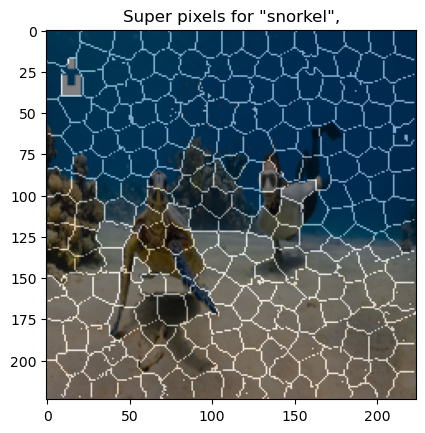

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 45.72it/s]


Predicting for class "snorkel",, 1000 perturbations
Printing the first 5 perturbations results:
Predicted class: "coral reef",
Predicted class: "coral reef",
Predicted class: "loggerhead sea turtle",
Predicted class: "coral reef",
Predicted class: "scuba diver",
22.6% of the predictions are correct to the label


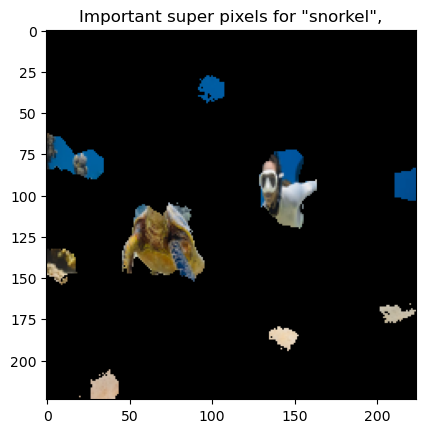

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 45.58it/s]


Predicting for class "loggerhead sea turtle",, 1000 perturbations
Printing the first 5 perturbations results:
Predicted class: "coral reef",
Predicted class: "loggerhead sea turtle",
Predicted class: "snorkel",
Predicted class: "coral reef",
Predicted class: "coral reef",
8.5% of the predictions are correct to the label


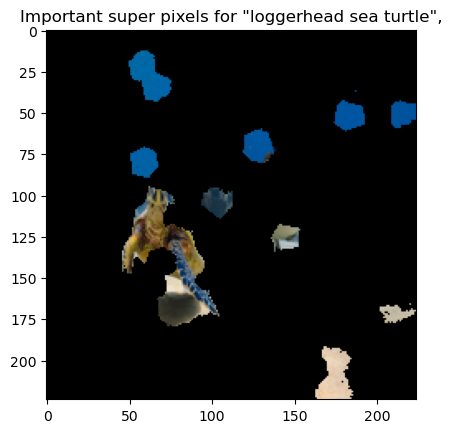

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:22<00:00, 44.57it/s]


Predicting for class "scuba diver",, 1000 perturbations
Printing the first 5 perturbations results:
Predicted class: "snorkel",
Predicted class: "coral reef",
Predicted class: "scuba diver",
Predicted class: "coral reef",
Predicted class: "scuba diver",
11.4% of the predictions are correct to the label


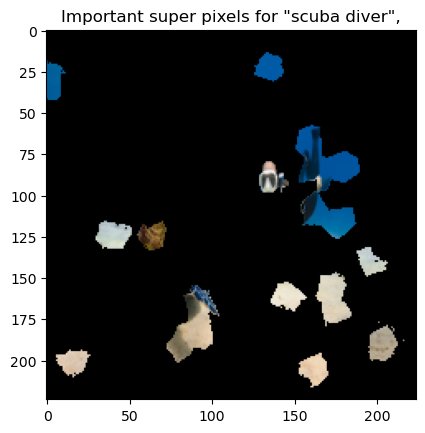

Top predicted classes:
"Yorkshire Terrier",
"Australian Terrier",
"Miniature Schnauzer",


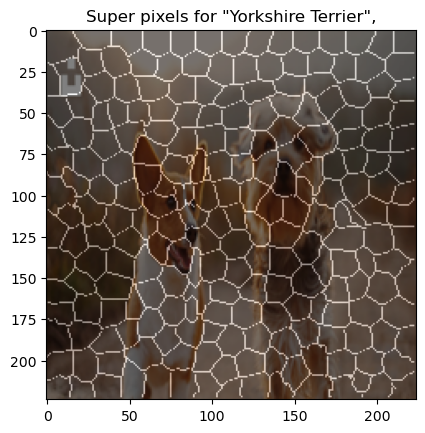

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 54.19it/s]


Predicting for class "Yorkshire Terrier",, 1000 perturbations
Printing the first 5 perturbations results:
Predicted class: "Norfolk Terrier",
Predicted class: "Basenji",
Predicted class: "Basenji",
Predicted class: "Yorkshire Terrier",
Predicted class: "Basenji",
5.4% of the predictions are correct to the label


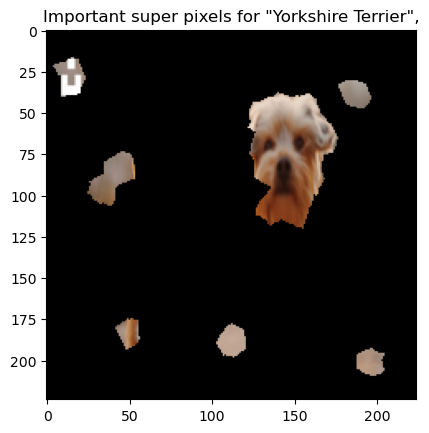

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 47.10it/s]


Predicting for class "Australian Terrier",, 1000 perturbations
Printing the first 5 perturbations results:
Predicted class: "Chihuahua",
Predicted class: "Basenji",
Predicted class: "Basenji",
Predicted class: "Welsh Springer Spaniel",
Predicted class: "Yorkshire Terrier",
1.0999999999999999% of the predictions are correct to the label


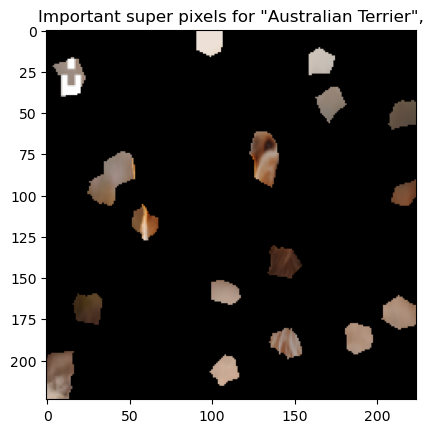

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 59.01it/s]


Predicting for class "Miniature Schnauzer",, 1000 perturbations
Printing the first 5 perturbations results:
Predicted class: "Basenji",
Predicted class: "Welsh Springer Spaniel",
Predicted class: "Basenji",
Predicted class: "West Highland White Terrier",
Predicted class: "Basenji",
0.3% of the predictions are correct to the label


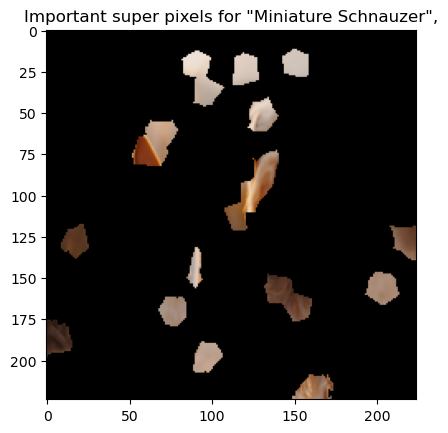

Top predicted classes:
"printer",
"toaster",
"tiger cat",


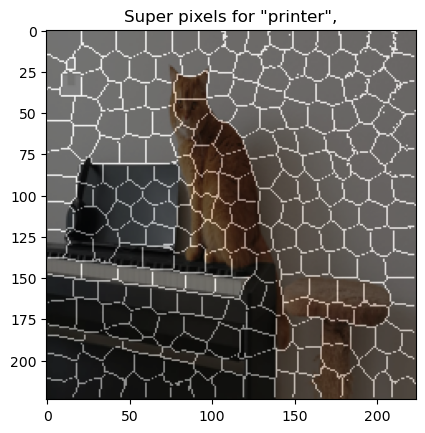

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 46.61it/s]


Predicting for class "printer",, 1000 perturbations
Printing the first 5 perturbations results:
Predicted class: "printer",
Predicted class: "printer",
Predicted class: "printer",
Predicted class: "printer",
Predicted class: "printer",
82.1% of the predictions are correct to the label


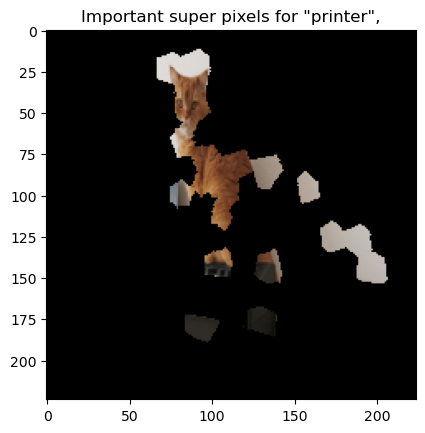

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 46.23it/s]


Predicting for class "toaster",, 1000 perturbations
Printing the first 5 perturbations results:
Predicted class: "printer",
Predicted class: "printer",
Predicted class: "printer",
Predicted class: "printer",
Predicted class: "printer",
0.0% of the predictions are correct to the label


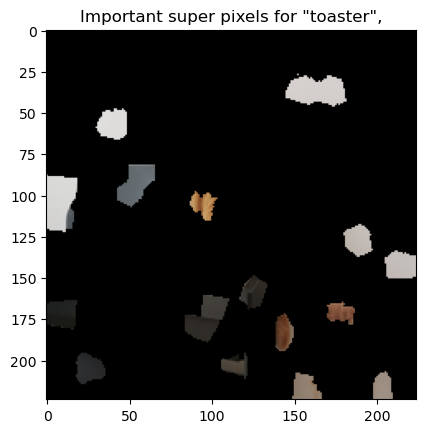

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 42.94it/s]


Predicting for class "tiger cat",, 1000 perturbations
Printing the first 5 perturbations results:
Predicted class: "printer",
Predicted class: "printer",
Predicted class: "teddy bear",
Predicted class: "printer",
Predicted class: "printer",
0.0% of the predictions are correct to the label


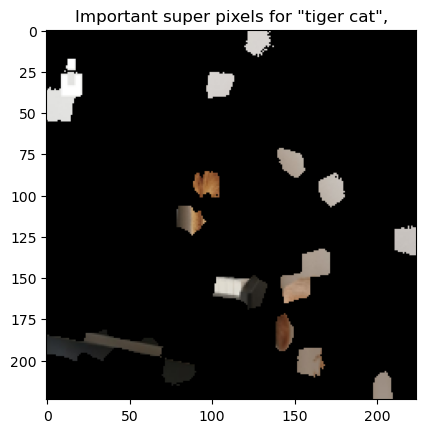

In [21]:
region_size = 15
perturbation_param = 6
n_perturbations = 1000

for image_path in Path(image_dir).iterdir():
    orig_img, top_3_classes, top_1_class_name = read_image_and_inference_and_plot(image_path, plot=False)

    # 4a
    # resize the image to 224x224
    orig_img = orig_img.resize((224, 224))
    image_as_array = np.array(orig_img)
    super_pixels, labels = get_super_pixels(image_as_array, region_size=region_size)
    plt.imshow(super_pixels)
    plt.title(f"Super pixels for {top_1_class_name}")
    plt.show()

    # 4b
    # Represent the interpretable instances as binary vectors. The entries of the vector correspond to inclusion/exclusion of the super pixels 𝑥$ ∈ {0,1}%!
    # one hot encode the labels
    num_of_super_pixels = len(np.unique(labels))
    one_hot_labels = np.zeros((labels.shape[0], labels.shape[1], num_of_super_pixels))
    for i in range(num_of_super_pixels):
        one_hot_labels[:, :, i] = (labels == i).astype(int)

    # 5a
    
    for class_index in top_3_classes:
    # i
        super_pixel_perturbations, super_pixel_labels = gen_random_perturbations(image_as_array, one_hot_labels, perturbation_param=perturbation_param, region_size=region_size, num_perturbations=n_perturbations)

        # ii
        # given the super_pixel_perturbations, and for each value !0, take the corresponding pixels from the original image
        bool_correct_current_class_predicted = []
        proximity_measures = []
        predictions = []
        print(f"Predicting for class {class_names[class_index]}, {len(super_pixel_perturbations)} perturbations")
        print("Printing the first 5 perturbations results:")
        for i, super_pixel_perturbation in enumerate(super_pixel_perturbations):
            super_pixel_perturbation = super_pixel_perturbations[i]
            perturbed_image_pil = Image.fromarray(super_pixel_perturbation)
            class_predicted = predict_image(perturbed_image_pil, k=1)
            predictions.append(class_names[class_predicted])
            if i < 5:
                print(f"Predicted class: {class_names[class_predicted]}")
            bool_correct_current_class_predicted.append(class_predicted == class_index)  # explanation: for each class of the top 3 classes, 
            # we want to know if the perturbed image was predicted the same as the current class, 
            # and that's what we train on later on (the simple m odel)
            # iii - Calculate the similarity of the perturbed instance from the original image 𝜋'(𝑧)
            proximity_measure = calc_similarity(image_as_array, super_pixel_perturbation)
            proximity_measures.append(proximity_measure)

        proximity_measures = np.array(proximity_measures)
        bool_correct_current_class_predicted = np.array(bool_correct_current_class_predicted)
        print(f"{bool_correct_current_class_predicted.sum() / len(predictions) * 100}% of the predictions are correct to the label")
        # 5b
        # i - Fit a linear model with locally weighted loss (using 𝜋') and 𝐿! regularization on the generated dataset. Use K-Lasso for feature selection.
        important_features = fit_linear_model_and_return_important_features(np.array(super_pixel_labels).squeeze(), bool_correct_current_class_predicted, proximity_measures, num_of_super_pixels, n=20)

        # ii - Find and present the set of important features (super-pixels/tiles) for the prediction 𝑓(𝑥)
        # get the super pixels of the important features
        important_features_indices = np.isin(labels, important_features)

        # get the super pixels of the important features
        important_super_pixels = np.zeros_like(image_as_array)
        important_super_pixels[important_features_indices] = image_as_array[important_features_indices]

        # plot the important super pixels
        plt.imshow(important_super_pixels)
        plt.title(f"Important super pixels for {class_names[class_index]}")
        plt.show()
